# FinBERT Data Augmentation Demo

This notebook demonstrates data augmentation techniques for enhancing FinBERT model performance:

1. Synonym Replacement (using nlpaug and financial domain-specific synonyms)
2. Back-Translation (using nlpaug)
3. LLM-Based Paraphrasing (using GPT-4o-mini)


In [1]:
# Add project root to path for imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

# Import required libraries
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import nlpaug.augmenter.word as naw
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables (for API keys)
load_dotenv()

# Import our custom modules (will be created later)
import sys
sys.path.append("..")
try:
    from scripts.data_augmentation import FinBertDataAugmenter
    from scripts.llm_paraphrase import LLMParaphraser
    print("Successfully imported custom modules")
except ImportError as e:
    print(f"Could not import custom modules: {e}")
    print("Make sure to run the cells after creating these files")


/Users/pasindusankalpa/Documents/finBERT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported custom modules


## 1. Load Training Data All Agreed dataset


In [2]:
# Load the training dataset
train_df = pd.read_csv('../data/sentiment_data/All_ageed/train.csv', sep='\t')
print(f"Training data size: {len(train_df)}")
print(f"Label distribution:\n{train_df['label'].value_counts()}")

train_df.head()


Training data size: 1629
Label distribution:
label
neutral     1002
positive     403
negative     224
Name: count, dtype: int64


,text,label
0,2009 3 February 2010 - Finland-based steel mak...,negative
1,"Turun kaupunkin , Finland based company has aw...",positive
2,Operating profit decreased to EUR 11.2 mn from...,negative
3,"The price of the 10,000 kroon par value bonds ...",neutral
4,Finnish shipping company Finnlines ' pretax lo...,negative


## 2. Initialize the Data Augmenter


In [3]:
# Initialize the data augmenter with FinBERT model
augmenter = FinBertDataAugmenter(
    model_name="ProsusAI/finbert",
    similarity_threshold=0.75
)


10/04/2025 16:00:02 - INFO - scripts.data_augmentation - Loading model: ProsusAI/finbert
10/04/2025 16:00:04 - INFO - scripts.data_augmentation - OpenAI client initialized successfully


## 4. Apply Data Augmentation to the Dataset


Get All Negative class train data

In [4]:
negative_df = train_df[train_df['label'] == 'negative']
print(f"Negative data size: {len(negative_df)}")
print(f"Negative label distribution:\n{negative_df['label'].value_counts()}")

#save the negative_df to a csv file with encoding utf-8 with "\t" as delimiter
negative_df.to_csv('../data/sentiment_data/All_ageed/negative_df.csv', sep='\t', encoding='utf-8', index=False)

# Augment the sample dataset

Negative data size: 224
Negative label distribution:
label
negative    224
Name: count, dtype: int64


Get All positive class training data

In [5]:
positive_df = train_df[train_df['label'] == 'positive']
print(f"Positive data size: {len(positive_df)}")
print(f"Positive label distribution:\n{positive_df['label'].value_counts()}")

#save the positive_df to a csv file with encoding utf-8 with "\t" as delimiter
positive_df.to_csv('../data/sentiment_data/All_ageed/positive_df.csv', sep='\t', encoding='utf-8', index=False)


Positive data size: 403
Positive label distribution:
label
positive    403
Name: count, dtype: int64


In [7]:
neutral_df = train_df[train_df['label'] == 'neutral']
print(f"Neutral data size: {len(neutral_df)}")
print(f"Neutral label distribution:\n{neutral_df['label'].value_counts()}")

#save the neutral_df to a csv file with encoding utf-8 with "\t" as delimiter   
neutral_df.to_csv('../data/sentiment_data/All_ageed/neutral_df.csv', sep='\t', encoding='utf-8', index=False)

Neutral data size: 1002
Neutral label distribution:
label
neutral    1002
Name: count, dtype: int64


In [8]:
neutral_df.head()

,text,label
3,"The price of the 10,000 kroon par value bonds ...",neutral
6,`` It wo n't happen overnight .,neutral
7,"From 2003 on , the emphasis of Kyro 's strateg...",neutral
9,"Currently , the company uses eight similar rea...",neutral
10,Incap Corporation Stock Exchange Announcement ...,neutral


For Neural dataset

In [ ]:
# Augment the sample dataset
augmented_df = augmenter.augment_dataframe(
    neutral_df,
    text_column='text',
    label_column='label',
    augment_percentage=1 # Augment 100% of the samples
)


Augmenting data:   0%|          | 0/250 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [23]:
augmented_df.head()

,text,label
0,Pertti Ervi is independent from the Company an...,neutral
1,Russia wants to utilise its huge forest reserv...,neutral
2,Operating profit totaled EUR 18.6 mn or 8.3 % ...,neutral
3,The value of the orders is over EUR 25mn .,neutral
4,Elcoteq SE Stock Exchange Announcement Februar...,neutral


In [24]:
# Compare before and after augmentation
print(f"Original neutral data size: {len(neutral_df)}")
print(f"Augmented neutral data size: {len(augmented_df)}")

print("\nLabel distribution:")
orig_dist = neutral_df['label'].value_counts().to_dict()
aug_dist = augmented_df['label'].value_counts().to_dict()

comparison = pd.DataFrame({
    'Original': orig_dist,
    'Augmented': aug_dist
}).fillna(0).astype(int)

print(comparison)


Original neutral data size: 1577
Augmented neutral data size: 2096

Label distribution:
         Original  Augmented
neutral      1577       2096


<Figure size 1000x600 with 0 Axes>

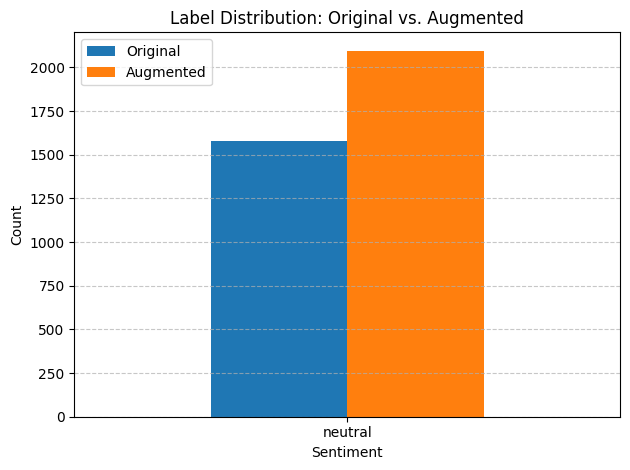

In [25]:
# Visualize the label distribution
plt.figure(figsize=(10, 6))
comparison.plot(kind='bar')
plt.title('Label Distribution: Original vs. Augmented')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


## 5. Examine Augmented Examples


In [26]:
# Find augmented samples (ones that appear in augmented_df but not in sample_df)
original_texts = set(neutral_df['text'])
new_samples = augmented_df[~augmented_df['text'].isin(original_texts)]

print(f"Number of newly generated samples: {len(new_samples)}")
new_samples.head(10)


Number of newly generated samples: 519


,text,label
1577,"The contract covers installation, training and...",neutral
1578,Tieto in Latvia is represented by IT services ...,neutral
1579,UPM-Kymmene said it has “no interest in any do...,neutral
1580,"On May 23, Alexandria, Virginia - Helsinki, Fi...",neutral
1581,"At some point in 2010, all individual company ...",neutral
1582,Ruokatalo Hong Kong’s goal is to understand co...,neutral
1583,CS Cabot 's main consumers on the Czech and Sl...,neutral
1584,CS Cabot's main consumers in the Czech and Slo...,neutral
1585,Feengon will turn the Salo division into a B2B...,neutral
1586,"With five different game modes, cooperative to...",neutral


In [27]:
#save the augmented neutral data
new_samples.to_csv('../data/sentiment_data/augmented_new_neutral_df.csv', index=False)


For Positive

In [28]:
# Augment the sample dataset
augmented_df = augmenter.augment_dataframe(
    positive_df,
    text_column='text',
    label_column='label',
    augment_percentage=1  # Augment 50% of the samples
)


Augmenting data:   0%|          | 1/610 [00:04<42:23,  4.18s/it]09/14/2025 14:18:13 - WARNING - scripts.data_augmentation - LLM paraphrasing requires API access. Using a simulated response.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pasindusankalpa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
09/14/2025 14:18:13 - WARNING - scripts.data_augmentation - Synonym augmentation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/pasindusankalpa/nltk_data'
    - '/Users/pasindusankalpa/Documents/finBERT/venv/nltk_data'
    - '/Users/pas

In [30]:
# Compare before and after augmentation
print(f"Original neutral data size: {len(positive_df)}")
print(f"Augmented neutral data size: {len(augmented_df)}")

print("\nLabel distribution:")
orig_dist = positive_df['label'].value_counts().to_dict()
aug_dist = augmented_df['label'].value_counts().to_dict()

comparison = pd.DataFrame({
    'Original': orig_dist,
    'Augmented': aug_dist
}).fillna(0).astype(int)

print(comparison)


Original neutral data size: 610
Augmented neutral data size: 799

Label distribution:
          Original  Augmented
positive       610        799


<Figure size 1000x600 with 0 Axes>

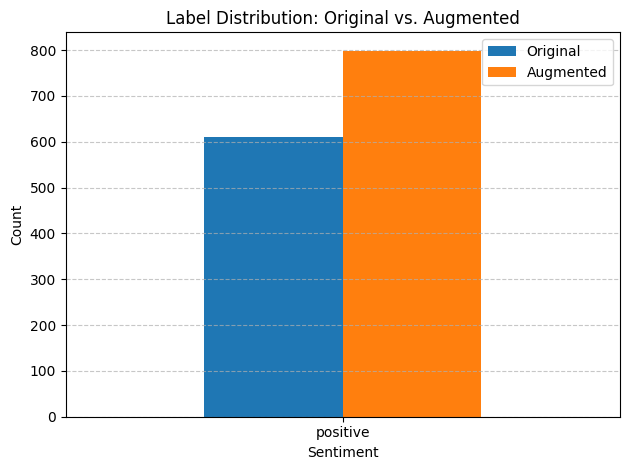

In [31]:
# Visualize the label distribution
plt.figure(figsize=(10, 6))
comparison.plot(kind='bar')
plt.title('Label Distribution: Original vs. Augmented')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
# Find augmented samples (ones that appear in augmented_df but not in sample_df)
original_texts = set(positive_df['text'])
new_samples = augmented_df[~augmented_df['text'].isin(original_texts)]

print(f"Number of newly generated samples: {len(new_samples)}")
new_samples.head(10)


Number of newly generated samples: 189


,text,label
610,Finnish high-tech provider Vaahto Group report...,positive
611,The airline has ordered nine Airbus A350-900 a...,positive
612,The deal will increase EPS to about 28 euros i...,positive
613,Net sales increased by 28% in the first half o...,positive
614,"October 20, 2010 - Finnish metal products comp...",positive
615,Finnish operators Elisa and Aker Yards have si...,positive
616,Clothing Chain SEPP+Nl+N net sales increased b...,positive
617,A spokesperson for Olvi said today to the topi...,positive
618,Earnings per share from January to June 2010 w...,positive
619,Unit costs for flight operations fell by 6.4%.,positive


In [33]:
#save the augmented positive data
new_samples.to_csv('../data/sentiment_data/augmented_new_positive_df.csv', index=False)

For negative

Augmenting data:   0%|          | 0/298 [00:00<?, ?it/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pasindusankalpa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
09/14/2025 14:33:50 - WARNING - scripts.data_augmentation - Synonym augmentation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/pasindusankalpa/nltk_data'
    - '/Users/pasindusankalpa/Documents/finBERT/venv/nltk_data'
    - '/Users/pasindusankalpa/Documents/finBERT/venv/share/nltk_data'
    - '/Users/pasindusankalpa/Documents/finBERT/venv/lib/nltk_data'
    - '/usr/s

Original neutral data size: 298
Augmented neutral data size: 376

Label distribution:
          Original  Augmented
negative       298        376


<Figure size 1000x600 with 0 Axes>

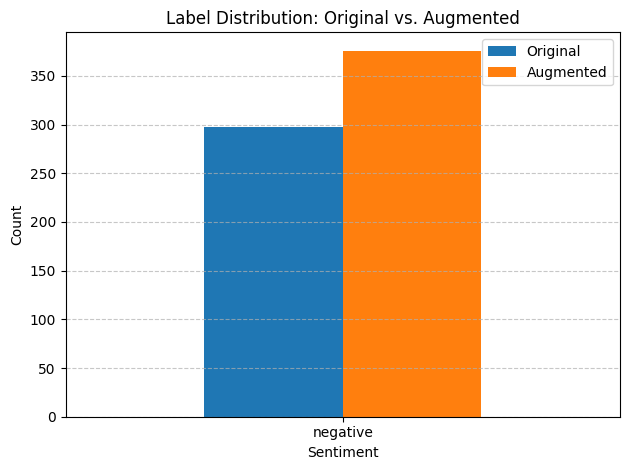

Number of newly generated samples: 78


In [34]:
# Augment the sample dataset
augmented_df = augmenter.augment_dataframe(
    negative_df,
    text_column='text',
    label_column='label',
    augment_percentage=1  # Augment 50% of the samples
)


# Compare before and after augmentation
print(f"Original neutral data size: {len(negative_df)}")
print(f"Augmented neutral data size: {len(augmented_df)}")

print("\nLabel distribution:")
orig_dist = negative_df['label'].value_counts().to_dict()
aug_dist = augmented_df['label'].value_counts().to_dict()

comparison = pd.DataFrame({
    'Original': orig_dist,
    'Augmented': aug_dist
}).fillna(0).astype(int)

print(comparison)

# Visualize the label distribution
plt.figure(figsize=(10, 6))
comparison.plot(kind='bar')
plt.title('Label Distribution: Original vs. Augmented')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Find augmented samples (ones that appear in augmented_df but not in sample_df)
original_texts = set(negative_df['text'])
new_samples = augmented_df[~augmented_df['text'].isin(original_texts)]

print(f"Number of newly generated samples: {len(new_samples)}")
new_samples.head(10)

#save the augmented negative data
new_samples.to_csv('../data/sentiment_data/augmented_new_negative_df.csv', index=False)


In [35]:
negative_augmented = pd.read_csv(
   "../data/sentiment_data/augmented_new_negative_df.csv"
)
# write the negative_augmented to a csv file with encoding utf-8 with "\t" as delimiter
negative_augmented.to_csv( "../data/sentiment_data/augmented_new_negative_df.csv", sep="\t", encoding="utf-8", index=False)

positive_augmented = pd.read_csv(
   "../data/sentiment_data/augmented_new_positive_df.csv"
)
# write the positive_augmented to a csv file with encoding utf-8 with "\t" as delimiter
positive_augmented.to_csv( "../data/sentiment_data/augmented_new_positive_df.csv", sep="\t", encoding="utf-8", index=False)


neutral_augmented = pd.read_csv(
   "../data/sentiment_data/augmented_new_neutral_df.csv"
)
# write the neutral_augmented to a csv file with encoding utf-8 with "\t" as delimiter
neutral_augmented.to_csv( "../data/sentiment_data/augmented_new_neutral_df.csv", sep="\t", encoding="utf-8", index=False)

   





## 6. Full Dataset Augmentation


In [ ]:
# To augment the full training dataset and save it to a file, uncomment the following:

# augmenter.augment_and_save(
#     input_path='../data/sentiment_data/train.csv',
#     output_path='../data/sentiment_data/train_augmented.csv',
#     text_column='text',
#     label_column='label',
#     augment_percentage=0.4  # Augment 40% of the samples
# )


## 7. Running the Full Pipeline

To run the full data augmentation and training pipeline, use the following command in the terminal:

```bash
python scripts/augment_and_train.py \
  --data_dir data/sentiment_data \
  --output_dir output \
  --augment_percentage 0.4 \
  --model_name ProsusAI/finbert \
  --num_train_epochs 4 \
  --use_cuda
```
